<a href="https://colab.research.google.com/github/yuukun123/Python/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Tùy chỉnh để hiển thị biểu đồ đẹp hơn
sns.set(style="whitegrid")

Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/Final_Cleaned_Database.xlsx")
print(df.to_string())

     Expression           Norming Survey  PainRating  FearRating  AngerRating  DisgustRating  HappinessRating  SadnessRating  SurpriseRating  ThreatRating  ConfusionRating      FearComp     AngerComp   DisgustComp  HappinessComp   SadnessComp  SurpriseComp    ThreatComp  ConfusionComp  Anger  Disgust  Fear       Sad  SmileClosed  SmileOpen  Surprise  BlinkLeft  BlinkRIght  BrowDownLeft  BrowDownRight  EpicanthicFold  EyeSquintLeft  EyeSquintRight   aah  B,M,P  big aah  ch,J,sh  D,S,T       F,V         K     N        oh  brow lowerer left  brow lowerer right   blink left  blink right  expression anger  expression baring teeth   expression disgust  expression fear  expression sad  expression smile right  expression smileclosed  expression smileopen  expression sneer  expression sneer left  expression surprise  modifier epicanthic fold  modifier eyesquint left  modifier eyesquint right  phoneme B,M,P  phoneme D,S,T  phoneme F,V  phoneme K  phoneme N  phoneme aah  phoneme big aah  phoneme 

In [4]:
# Đường dẫn file
file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DelawarePainDatabase_SecondaryDatabase_FaceGenCharacterization.xlsx"
xls = pd.ExcelFile(file_path)

hàm lọc dữ liệu sheet ExpressionAverage


In [5]:
# def clean_expression_sheet(df, required_cols=["Expression"]):
#     # Xóa cột không tên
#     df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

#     # Xóa dòng thiếu cột bắt buộc
#     df = df.dropna(subset=required_cols)

#     # Loại bỏ các biểu cảm không dùng
#     df = df[~df["Expression"].str.lower().str.contains("pms13")]
#     df = df[~df["Expression"].str.lower().str.contains("facegenpro_avgblackface")]

#     # Các cột cần ép kiểu và xử lý NaN
#     numeric_cols = ["ThreatRating", "ConfusionRating", "ThreatComp", "ConfusionComp"]
#     for col in numeric_cols:
#         if col in df.columns:
#             df[col] = df[col].replace([".", ""], np.nan)
#             df[col] = pd.to_numeric(df[col], errors="coerce")
#             df[col] = df[col].fillna(df[col].mean())

#     # Loại bỏ các dòng liên quan face gen pro
#     df = df[~df["Norming Survey"].str.lower().str.contains("facegenpro")]

#     df = df.infer_objects(copy=False)

#     return df


In [6]:
def clean_expression_sheet(df, required_cols=["Expression"]):
  # Xóa cột không tên
  df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

  # Xóa dòng thiếu cột bắt buộc
  df = df.dropna(subset=required_cols)

  # Loại bỏ các biểu cảm không dùng
  df = df[~df["Expression"].str.lower().str.contains("pms13")]
  df = df[~df["Expression"].str.lower().str.contains("facegenpro_avgblackface")]

  # ✅ Loại bỏ các dòng liên quan face gen pro TRƯỚC để không ảnh hưởng đến mean
  df = df[~df["Norming Survey"].str.lower().str.contains("facegenpro")]

  # Các cột cần ép kiểu và xử lý NaN
  numeric_cols = ["ThreatRating", "ConfusionRating", "ThreatComp", "ConfusionComp"]
  for col in numeric_cols:
      if col in df.columns:
          df[col] = df[col].replace([".", ""], np.nan)
          df[col] = pd.to_numeric(df[col], errors="coerce")
          df[col] = df[col].fillna(df[col].mean())

  df = df.loc[:, ~df.columns.str.contains("ConfusionRating")]
  df = df.loc[:, ~df.columns.str.contains("ConfusionComp")]

  df = df.infer_objects(copy=False)
  return df


ExpressionAverages

In [7]:
df_expr = pd.read_excel(xls, sheet_name="ExpressionAverages")
# print(df_expr.dtypes)
df_expr = clean_expression_sheet(df_expr)

print(df_expr.to_string())

   Expression Norming Survey  PainRating  FearRating  AngerRating  DisgustRating  HappinessRating  SadnessRating  SurpriseRating  ThreatRating      FearComp     AngerComp   DisgustComp  HappinessComp   SadnessComp  SurpriseComp    ThreatComp
0         AJ2      FirstPass    5.052632    2.894737     2.078947       2.421053         1.210526       3.131579        2.131579      1.736842  2.033766e-06  9.570970e-08  3.064130e-07   1.954638e-12  1.372440e-04  6.551333e-07  3.610371e-09
3         AK5      FirstPass    4.650000    2.225000     2.725000       2.575000         1.275000       2.275000        1.725000      2.375000  7.102722e-09  4.114614e-05  2.849266e-06   6.427339e-13  3.038153e-08  1.352565e-10  1.223136e-07
6         EF5      FirstPass    5.837838    2.594595     4.378378       3.162162         1.324324       1.864865        2.378378      3.351351  1.203900e-09  3.054509e-03  2.977539e-07   2.203910e-15  3.098174e-13  5.076302e-11  6.699533e-06
9         KM4      FirstPass    

<ipython-input-6-63b2d55437d4>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace([".", ""], np.nan)


hàm lọc dữ liệu sheet slider_face_gen

In [8]:
def clean_slider_facegen_sheet(df):

  # Xóa các cột không tên (thường là chú thích hoặc rỗng)
  df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

  # Loại bỏ cột 'PMS13' nếu có (theo khuyến nghị)
  if "PMS13" in df.columns:
      df = df.drop(columns=["PMS13"])

  # Duyệt qua tất cả các cột trừ 'Slider'
  numeric_cols = df.columns.drop("Slider")
  for col in numeric_cols:
      # Thay "." và chuỗi rỗng thành NaN
      df[col] = df[col].replace([".", ""], np.nan)

      # Ép kiểu thành số (sai sẽ thành NaN)
      df[col] = pd.to_numeric(df[col], errors="coerce")

      # Điền thiếu bằng trung bình cột
      df[col] = df[col].fillna(df[col].mean())

  # Bỏ cảnh báo downcasting
  df = df.infer_objects(copy=False)

  return df


Slider_face_gen

In [9]:
df_slider_mo = pd.read_excel(xls, sheet_name="Sliders_FaceGenModeller")
# print(df_slider_mo.dtypes)
df_slider_mo = clean_slider_facegen_sheet(df_slider_mo)
print(df_slider_mo.to_string())

            Slider       AK5    AJ2     EF5      KM4   KM4b      PMS5      PMS7    PMS14      PMS2  PMS8
0            Anger  0.220000  0.438  0.8400  0.87375  0.849  0.950000  0.070000  0.75000  0.350000  0.15
1          Disgust  0.480000  0.210  0.8700  0.77000  0.770  0.595714  1.000000  0.39000  0.750000  1.00
2             Fear  0.551818  1.000  0.5125  0.87375  0.849  0.595714  0.811111  0.69125  0.530909  0.47
3              Sad  0.830000  1.000  1.0000  1.00000  1.000  1.000000  1.000000  1.00000  1.000000  1.00
4      SmileClosed  0.551818  0.438  0.4600  1.00000  1.000  0.700000  1.000000  0.69125  1.000000  1.00
5        SmileOpen  0.551818  0.800  0.1300  0.87375  0.500  0.140000  0.230000  0.13000  0.530909  0.47
6         Surprise  0.551818  0.438  0.5125  0.87375  0.849  0.595714  0.811111  0.69125  0.400000  0.20
7        BlinkLeft  0.560000  0.150  0.5125  0.87375  0.849  0.200000  0.811111  0.69125  0.300000  0.13
8       BlinkRIght  0.570000  0.140  0.5125  0.87375  0

<ipython-input-8-57b868a77ba0>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace([".", ""], np.nan)


hàm lọc first_pass_norming

In [10]:
# def clean_first_pass_norming(df):
#     import pandas as pd


#     # 1. Loại cột chứa 'pms13'
#     df = df.loc[:, ~df.columns.str.contains("pms13", case=False)]

#     # 2. Loại bỏ các cột nhân khẩu học không cần thiết
#     drop_cols = ['Race', 'SexualOrient', 'Political']
#     df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

#     # 3. Tìm các cột đánh giá cảm xúc
#     rating_cols = [c for c in df.columns if "emotion" in c.lower()]

#     # 4. Tính tỷ lệ thiếu
#     miss_ratios = df[rating_cols].isna().mean()

#     # 5. Giữ lại các cột có missing <= 0.4
#     keep_cols = miss_ratios[miss_ratios <= 0.4].index.tolist()
#     df = df[keep_cols + [col for col in df.columns if col not in rating_cols]]

#     # 6. Phân loại cột theo mức độ thiếu
#     small_missing = miss_ratios[miss_ratios < 0.05].index.tolist()
#     large_missing = miss_ratios[(miss_ratios >= 0.05) & (miss_ratios <= 0.4)].index.tolist()

#     # 7. Drop dòng chứa missing < 5%
#     df = df.dropna(subset=small_missing)

#     # 8. Điền missing >= 5% bằng mode
#     for col in large_missing:
#         mode_val = df[col].mode().iat[0]
#         df[col] = df[col].fillna(mode_val).astype(int)

#     # 9. Reshape wide → long format
#     id_vars = ['ResponseId', 'Age', 'Gender']
#     id_vars = [col for col in id_vars if col in df.columns]

#     long_df = df.melt(
#         id_vars=id_vars,
#         value_vars=keep_cols,
#         var_name="Item",
#         value_name="Rating"
#     )

#     # 10. Tách thông tin từ tên cột: ImageID, EmotionType, QuestionNumber
#     long_df[['ImageID', 'EmotionType', 'QuestionNum']] = long_df['Item'].str.extract(r'([A-Za-z0-9_]+)_([a-zA-Z0-9]+)_([0-9]+)')

#     # 11. Xử lý kiểu dữ liệu
#     long_df['Rating'] = pd.to_numeric(long_df['Rating'], errors='coerce')
#     long_df['QuestionNum'] = pd.to_numeric(long_df['QuestionNum'], errors='coerce')

#     return long_df


In [11]:
# def clean_first_pass_norming(df):
#     # 1. Loại bỏ các cột chứa 'pms13'
#     df = df.loc[:, ~df.columns.str.contains("pms13", case=False)]

#     # 2. Bỏ dòng đầu tiên (header mô tả)
#     df = df.drop(index=0).reset_index(drop=True)

#     # 3. Tìm các cột cảm xúc
#     emotion_cols = [col for col in df.columns if "_emotion_" in col]

#     # 4. Chuẩn bị metadata: Age, Gender
#     df_meta = df[['ResponseId', 'Age', 'Gender']].copy()

#     df_meta['Age'] = pd.to_numeric(df_meta['Age'], errors='coerce')
#     df_meta['Gender'] = df_meta['Gender'].str.strip().str.lower()

#     # ✅ Chuẩn hóa Gender: female = 0, male = 1
#     gender_map = {'female': 0, 'male': 1}
#     df_meta['Gender'] = df_meta['Gender'].map(gender_map)

#     # ✅ Xóa các dòng Gender không hợp lệ (NaN)
#     df_meta = df_meta.dropna(subset=['Gender'])

#     # 5. Chuyển về dạng long format
#     df_long = df.melt(id_vars=['ResponseId'], value_vars=emotion_cols,
#                       var_name='Image_ID', value_name='Emotion')

#     # 6. Bỏ các dòng không có nhãn
#     df_long.dropna(subset=['Emotion'], inplace=True)

#     # 7. Trích tên file ảnh từ tên cột
#     df_long['ExpressionKey'] = df_long['Image_ID'].str.extract(r'([A-Za-z0-9]+)_emotion_\d+')[0]
#     df_long['ImageFile'] = df_long['ExpressionKey'] + ".jpg"

#     # ✅ 7.5. Lọc các ảnh có ExpressionKey hợp lệ
#     valid_expressions = ["AJ2", "AK5", "EF5", "KM4", "KM4b", "PMS5", "PMS7", "PMS14"]
#     df_long = df_long[df_long['ExpressionKey'].isin(valid_expressions)]

#     # 8. Đổi kiểu nhãn cảm xúc sang số
#     df_long['Emotion'] = df_long['Emotion'].astype(int)

#     # 9. Merge thêm Age và Gender
#     df_long = df_long.merge(df_meta, on='ResponseId', how='inner')

#     return df_long


In [12]:
def clean_first_pass_norming(df):
    # 1. Loại bỏ các cột chứa 'pms13'
    df = df.loc[:, ~df.columns.str.contains("pms13", case=False)]

    # 2. Bỏ dòng đầu tiên (header mô tả)
    df = df.drop(index=0).reset_index(drop=True)

    # 3. Tìm các cột cảm xúc
    emotion_cols = [col for col in df.columns if "_emotion_" in col]

    # 4. Chuẩn bị metadata: Age, Gender
    df_meta = df[['ResponseId', 'Age', 'Gender']].copy()

    df_meta['Age'] = pd.to_numeric(df_meta['Age'], errors='coerce')
    df_meta['Gender'] = df_meta['Gender'].str.strip().str.lower()

    # ✅ Chuẩn hóa Gender: female = 0, male = 1
    gender_map = {'female': 0, 'male': 1}
    df_meta['Gender'] = df_meta['Gender'].map(gender_map)

    # ✅ Xóa các dòng Gender không hợp lệ (NaN)
    df_meta = df_meta.dropna(subset=['Gender'])

    # 5. Chuyển về dạng long format
    df_long = df.melt(id_vars=['ResponseId'], value_vars=emotion_cols,
                      var_name='Image_ID', value_name='Emotion')

    # 6. Bỏ các dòng không có nhãn
    df_long.dropna(subset=['Emotion'], inplace=True)

    # 7. Trích tên file ảnh từ tên cột
    # Ví dụ tên ảnh: AF1_AJ2.jpg
    # df_long['ExpressionKey'] = df_long['Image_ID'].str.extract(r'_[A-Z]*([A-Za-z0-9]+)_emotion_\d+')[0]

    df_long['ExpressionKey'] = df_long['Image_ID'].str.extract(r'([A-Za-z0-9]+)_emotion_\d+')[0]
    df_long['ImageFile'] = df_long['ExpressionKey'] + ".jpg"

    # ✅ 7.5. Lọc các ảnh có ExpressionKey hợp lệ
    valid_expressions = ["AJ2", "AK5", "EF5", "KM4", "KM4b", "PMS5", "PMS7", "PMS14"]
    df_long = df_long[df_long['ExpressionKey'].isin(valid_expressions)]

    # 8. Đổi kiểu nhãn cảm xúc sang số
    df_long['Emotion'] = df_long['Emotion'].astype(int)

    # 9. Merge thêm Age và Gender
    df_long = df_long.merge(df_meta, on='ResponseId', how='inner')

    return df_long


Fist_pass_norming

In [13]:
df_first = pd.read_excel(xls, sheet_name="FirstPassNorming")
df_first = clean_first_pass_norming(df_first)


print(df_first.to_string())
# df_first.info()
# df_first.head()


             ResponseId          Image_ID  Emotion ExpressionKey  ImageFile  Age  Gender
0     R_2zw5psM5CtFQKno    EF5_emotion_18        4           EF5    EF5.jpg   26     1.0
1     R_2Ua2Dc353v4cNGn    EF5_emotion_18        2           EF5    EF5.jpg   32     0.0
2     R_2YR34dGGiKYFi2y    EF5_emotion_18        7           EF5    EF5.jpg   64     0.0
3     R_BWYpKelNH9C8aRj    EF5_emotion_18        1           EF5    EF5.jpg   24     1.0
4     R_2an0MfrT5MWzwiQ    EF5_emotion_18        7           EF5    EF5.jpg   45     0.0
5     R_3PGE13wEeq6tIOT    EF5_emotion_18        1           EF5    EF5.jpg   21     1.0
6     R_1lzUZmKRQVzOpxD    EF5_emotion_18        6           EF5    EF5.jpg   39     1.0
7     R_31uzrii0srEgLi3    EF5_emotion_18        1           EF5    EF5.jpg   59     0.0
8     R_27U5GunQGBeN6FX    EF5_emotion_18        1           EF5    EF5.jpg   31     0.0
9     R_3oYotaD13IZxRGi    EF5_emotion_18        1           EF5    EF5.jpg   25     1.0
10    R_2B4ImrFXFEt8L

hàm lọc demographics

In [14]:
def clean_demographics(df):
    # 0. Giữ lại hai cột đầu tiên (giả sử là cột chứa Age và Gender)
    df = df.iloc[:, :2]

    # 1. Đặt tên cột
    df.columns = ['Age', 'Gender']  # Đặt tên cột là "Age" và "Gender"

    # 2. Xóa dòng đầu tiên (Age, Gender)
    df = df.drop(index=0).reset_index(drop=True)

    # 3. Chuẩn hóa cột Gender: Female -> 0, Male -> 1, các giá trị khác -> NaN
    df['Gender'] = df['Gender'].astype(str).str.strip().str.lower()
    gender_map = {'female': 0, 'male': 1}
    df['Gender'] = df['Gender'].map(gender_map).where(df['Gender'].isin(['female', 'male']), np.nan)

    return df

Demographics

In [15]:
df_demographics = pd.read_excel(xls, sheet_name="Demographics")
df_demographics = clean_demographics(df_demographics)
print(df_demographics.to_string())


   Age  Gender
0   25       0
1   26       1
2   49       0
3   32       0
4   64       0
5   36       0
6   49       1
7   32       0
8   25       1
9   24       1
10  45       0
11  32       0
12  21       1
13  39       1
14  59       0
15  31       0
16  39       1
17  31       1
18  39       1
19  48       0
20  25       1
21  40       0
22  24       1
23  40       0
24  27       1
25  36       1
26  26       0
27  35       1
28  36       1
29  26       1
30  37       1
31  61       1
32  48       1
33  31       0
34  36       0
35  33       0
36  21       0
37  46       1
38  46       1
39  40       1
40  28       0
41  44       1
42  51       0
43  45       0
44  49       0
45  31       1
46  36       1
47  20       0
48  43       1
49  23       1
50  44       0
51  43       0
52  52       0
53  34       1
54  75       1
55  40       0
56  39       0
57  40       0
58  61       0
59  27       0
60  49       1
61  40       0
62  29       0
63  29       1
64  25       1
65  35    

In [16]:
# Giả sử 4 DataFrame đã tồn tại: df_expr, df_slider_mo, df_first, df_demographics

# Ghi vào file Excel với 4 sheet
with pd.ExcelWriter('/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx') as writer:
    df_expr.to_excel(writer, sheet_name='Expression', index=False)
    df_slider_mo.to_excel(writer, sheet_name='Slider_MO', index=False)
    df_first.to_excel(writer, sheet_name='First', index=False)
    df_demographics.to_excel(writer, sheet_name='Demographics', index=False)

print("save successful")


save successful


In [17]:
# # Đường dẫn thư mục lưu file CSV
# output_dir = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/'

# # Lưu từng DataFrame vào file CSV riêng
# df_expr.to_csv(output_dir + 'Expression.csv', index=False)
# df_slider_mo.to_csv(output_dir + 'Slider_MO.csv', index=False)
# df_first.to_csv(output_dir + 'First.csv', index=False)
# df_demographics.to_csv(output_dir + 'Demographics.csv', index=False)

In [18]:
# # Đường dẫn tới file Excel nhiều sheet
# xlsx_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx"  # hoặc đường dẫn đầy đủ nếu cần

# # Đọc tất cả các sheet vào dict
# all_sheets = pd.read_excel(xlsx_path, sheet_name=None)

# # Gộp tất cả sheet lại thành một DataFrame
# merged_df = pd.concat(all_sheets.values(), ignore_index=True)

# # Lưu ra Excel
# merged_df.to_excel("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_cleaned.xlsx", index=False)

# # Lưu ra CSV
# merged_df.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_cleaned.csv", index=False)

In [19]:
# import pandas as pd

# # Đọc file Excel
# file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx"
# xls = pd.ExcelFile(file_path)

# # Đọc các sheet
# df_expression = xls.parse("Expression")
# df_slider = xls.parse("Slider_MO")
# df_first = xls.parse("First")
# df_demo = xls.parse("Demographics")

# # --- Bước 1: Transpose Slider_MO để phù hợp với Expression ---
# df_slider_t = df_slider.set_index('Slider').T.reset_index()
# df_slider_t = df_slider_t.rename(columns={'index': 'Expression'})

# # Merge với Expression theo cột "Expression"
# df_merged_exp = pd.merge(df_expression, df_slider_t, on="Expression", how="left")

# # --- Bước 2: Gộp Demographics vào First (giả định thứ tự dòng giống nhau) ---
# df_first_demo = pd.concat([df_first.reset_index(drop=True), df_demo.reset_index(drop=True)], axis=1)

# # --- Bước 3: Chuẩn hóa mã ảnh từ ImageFile để merge ---
# df_first_demo['ImageCode'] = df_first_demo['ImageFile'].str.extract(r'([A-Z]+\d+[a-zA-Z]?)')

# # Merge First + Demographics với dữ liệu biểu cảm
# df_final = pd.merge(df_first_demo, df_merged_exp, left_on='ImageCode', right_on='Expression', how='left')

# # Xuất hoặc lưu file nếu cần:
# # df_final.to_excel("merged_output.xlsx", index=False)

# # Hiển thị một vài dòng để kiểm tra
# print(df_final.head())


In [31]:
import pandas as pd

# Đường dẫn tới file Excel
file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx"
xls = pd.ExcelFile(file_path)

# Đọc các sheet cần thiết
df_first = pd.read_excel(xls, sheet_name="First")
df_expression = pd.read_excel(xls, sheet_name="Expression")

# Làm sạch key bên First
df_first['ExpressionKey'] = df_first['ImageFile'].str.replace('.jpg', '', regex=False)
df_first['ExpressionKey'] = df_first['ExpressionKey'].str.strip().str.upper()

# Làm sạch key bên Expression
df_expression['Expression'] = df_expression['Expression'].astype(str).str.strip().str.upper()

# Merge lại theo ExpressionKey
df_merged = df_first.merge(df_expression, left_on='ExpressionKey', right_on='Expression', how='left')

# Giữ lại các cột mong muốn
cols_to_keep = [
    'ImageFile', 'Emotion',  # từ First
    'PainRating', 'FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
    'SadnessRating', 'SurpriseRating', 'ThreatRating',
    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
    'SadnessComp', 'SurpriseComp', 'ThreatComp'
]

df_final = df_merged[cols_to_keep].dropna(subset=['PainRating'])  # lọc các dòng không có PainRating

# In thử kết quả
print(df_final.head())

# Nếu muốn lưu lại:
df_final.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv", index=False)


  ImageFile  Emotion  PainRating  FearRating  AngerRating  DisgustRating  \
0   EF5.jpg        4    5.837838    2.594595     4.378378       3.162162   
1   EF5.jpg        2    5.837838    2.594595     4.378378       3.162162   
2   EF5.jpg        7    5.837838    2.594595     4.378378       3.162162   
3   EF5.jpg        1    5.837838    2.594595     4.378378       3.162162   
4   EF5.jpg        7    5.837838    2.594595     4.378378       3.162162   

   HappinessRating  SadnessRating  SurpriseRating  ThreatRating      FearComp  \
0         1.324324       1.864865        2.378378      3.351351  1.203900e-09   
1         1.324324       1.864865        2.378378      3.351351  1.203900e-09   
2         1.324324       1.864865        2.378378      3.351351  1.203900e-09   
3         1.324324       1.864865        2.378378      3.351351  1.203900e-09   
4         1.324324       1.864865        2.378378      3.351351  1.203900e-09   

   AngerComp   DisgustComp  HappinessComp   SadnessComp 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv")
print(df.to_string())



Tổng ảnh hợp lệ: 128
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - loss: 49.7089 - mae: 6.0309 - val_loss: 22.9231 - val_mae: 4.7810
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - loss: 19.1584 - mae: 4.3052 - val_loss: 0.5003 - val_mae: 0.6674
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - loss: 2.0349 - mae: 1.1936 - val_loss: 1.1449 - val_mae: 1.0417
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - loss: 1.4510 - mae: 0.9889 - val_loss: 0.0591 - val_mae: 0.1831
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - loss: 1.1963 - mae: 0.8698 - val_loss: 0.2707 - val_mae: 0.4866
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - loss: 1.0714 - mae: 0.8159 - val_loss: 0.2218 - val_mae: 0.4036
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - loss: 0.7150 - mae: 0.6895 - val_loss: 0.0865 - val_mae: 0.2541
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - loss: 1.0380 - mae: 0.8200 - val_loss: 0.7101 - val_mae: 0.8079
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/ste

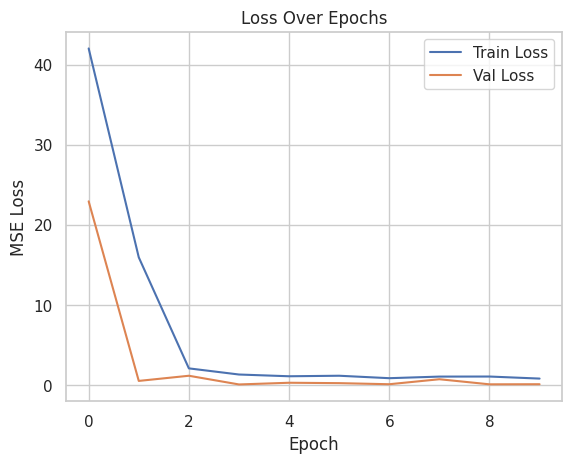

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate

# 👉 BƯỚC 1: ĐƯỜNG DẪN
IMAGE_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller"
CSV_PATH = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv"  # chứa các cột cảm xúc

# 👉 BƯỚC 2: ĐỌC LABEL
emotion_features = ['FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
                    'SadnessRating', 'SurpriseRating', 'ThreatRating',
                    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
                    'SadnessComp', 'SurpriseComp', 'ThreatComp']

cols_to_use = ['ImageFile', 'PainRating'] + emotion_features

df = pd.read_csv(CSV_PATH)
df = df[cols_to_use].dropna()

# 👉 BƯỚC 3: LOAD ẢNH & TÍCH HỢP FEATURES
X_img, X_meta, y = [], [], []

for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            img_path = os.path.join(root, file)
            if "_" in file:
                image_file_part = file.split("_")[-1]  # ví dụ EF5.jpg

                label_row = df[df['ImageFile'] == image_file_part]
                if not label_row.empty:
                    try:
                        img = load_img(img_path, target_size=(128, 128))
                        img_array = img_to_array(img) / 255.0

                        meta_row = label_row[emotion_features].values[0]

                        X_img.append(img_array)
                        X_meta.append(meta_row)
                        y.append(label_row['PainRating'].values[0])
                    except Exception as e:
                        print(f"Lỗi xử lý ảnh {file}: {e}")

X_img = np.array(X_img)
X_meta = np.array(X_meta)
y = np.array(y)

print("Tổng ảnh hợp lệ:", len(X_img))

# 👉 BƯỚC 4: CHIA DỮ LIỆU
X_img_train, X_img_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    X_img, X_meta, y, test_size=0.3, random_state=42)

X_img_val, X_img_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    X_img_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42)

# 👉 BƯỚC 5: MÔ HÌNH MULTIMODAL
# Nhánh ảnh
img_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3,3), activation='relu')(img_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

# Nhánh cảm xúc (metadata)
meta_input = Input(shape=(len(emotion_features),))
m = Dense(32, activation='relu')(meta_input)

# Kết hợp 2 nhánh
combined = Concatenate()([x, m])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1)(z)

model = Model(inputs=[img_input, meta_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 👉 BƯỚC 6: TRAIN
history = model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_val, X_meta_val], y_val),
    epochs=10,
    batch_size=16
)

# 👉 BƯỚC 7: ĐÁNH GIÁ
loss, mae = model.evaluate([X_img_test, X_meta_test], y_test)
print(f"\n🎯 Test MAE: {mae:.2f}")

# 👉 BƯỚC 8: VẼ LOSS
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Đường dẫn test
test_image_path = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller/BM3/BM3_PMS5.jpg"
test_image_file = "EF5.jpg"  # So sánh với cột ImageFile

# 👉 Tìm hàng tương ứng trong DataFrame gốc
row = df[df["ImageFile"] == test_image_file]
if row.empty:
    print("❌ Không tìm thấy đặc trưng cảm xúc tương ứng.")
else:
    try:
        # Load ảnh
        img = load_img(test_image_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Lấy đặc trưng cảm xúc từ đúng DataFrame
        meta = row[emotion_features].iloc[0].to_numpy(dtype=np.float32).reshape(1, -1)

        # Dự đoán
        prediction = model.predict([img_array, meta])[0][0]
        print(f"📷 Ảnh: {test_image_file} → 🎯 PainRating dự đoán: {prediction:.2f}")
    except Exception as e:
        print(f"❌ Lỗi khi dự đoán: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
📷 Ảnh: EF5.jpg → 🎯 PainRating dự đoán: 5.61


In [60]:
import pandas as pd

# Đường dẫn đến tệp .xlsx
input_file = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_output.xlsx'  # Thay bằng đường dẫn tệp của bạn
output_file = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.xlsx'  # Tên tệp .csv đầu ra


# Đọc tệp .xlsx
df = pd.read_excel(input_file)

df = df.drop(columns=['ResponseId'])

df.head()

# Lưu dưới dạng .csv
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Đã chuyển đổi {input_file} sang {output_file}")


Đã chuyển đổi /content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_output.xlsx sang /content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.xlsx


✅ Tổng ảnh hợp lệ: 128
✅ Train: 88 | Val: 16 | Test: 24


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 126, 126,  │        896 │ input_layer_21[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 63, 63,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 30, 30,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │        480 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │      1,120 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 57664)     │          0 │ flatten_9[0][0],  │
│ (Concatenate)       │                   │            │ dense_30[0][0],   │
│                     │                   │            │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │  7,381,120 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │        129 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,402,241 (28.24 MB)

 Trainable params: 7,402,241 (28.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - loss: 154.5686 - mae: 9.2754 - val_loss: 29.2274 - val_mae: 5.3965
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - loss: 25.5491 - mae: 4.9985 - val_loss: 13.2636 - val_mae: 3.6278
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - loss: 10.5386 - mae: 3.1432 - val_loss: 0.7186 - val_mae: 0.7861
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - loss: 2.2767 - mae: 1.2041 - val_loss: 1.8158 - val_mae: 1.3100
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 3.5893 - mae: 1.5732 - val_loss: 2.3389 - val_mae: 1.4965
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 3.0688 - mae: 1.5003 - val_loss: 0.1186 - val_mae: 0.2760
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - loss: 1.8698 - mae: 1.0915 - val_loss: 0.4588 - val_mae: 0.6009
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - loss: 1.8350 - mae: 1.0694 - val_loss: 1.4227 - val_mae: 1.1513
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - loss: 1.8091 -

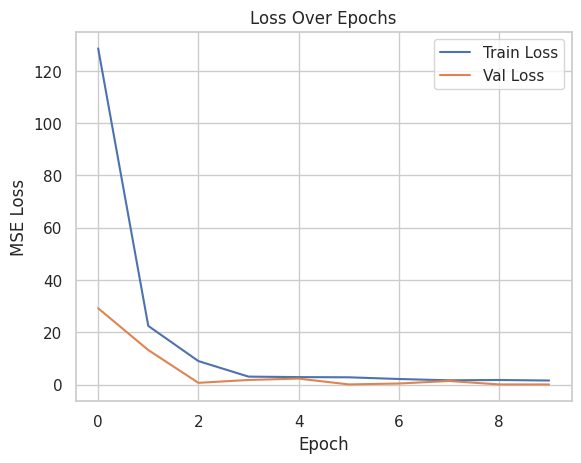

In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate

# 👉 BƯỚC 1: ĐƯỜNG DẪN
IMAGE_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller"
CSV_PATH = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.csv"

# 👉 BƯỚC 2: ĐỌC CSV & CHUẨN HÓA TÊN CỘT
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(",", ".", regex=False)

# 👉 BƯỚC 3: CHỌN CÁC CỘT ĐẶC TRƯNG
emotion_features = [
    'FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
    'SadnessRating', 'SurpriseRating', 'ThreatRating',
    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
    'SadnessComp', 'SurpriseComp', 'ThreatComp'
]

face_features = [
    'Anger', 'Disgust', 'Fear', 'Sad', 'SmileClosed', 'SmileOpen', 'Surprise',
    'BlinkLeft', 'BlinkRIght', 'BrowDownLeft', 'BrowDownRight', 'BrowInLeft',
    'BrownInRight', 'BrowUpLeft', 'BrowUpRight', 'EarsOut', 'EpicanthicFold',
    'EyeSquintLeft', 'EyeSquintRight', 'LookDown', 'LookLeft', 'LookRight',
    'LookUp', 'aah', 'B,M,P', 'big aah', 'ch,J,sh', 'D,S,T', 'ee', 'eh', 'F,V',
    'i', 'K', 'N', 'oh', 'ooh,Q', 'R', 'th', 'W'
]

# Lọc chỉ giữ cột có trong CSV
face_features = [col for col in face_features if col in df.columns]
df = df.dropna(subset=['ImageFile', 'PainRating'] + emotion_features + face_features)

# 👉 BƯỚC 4: LOAD ẢNH & TRÍCH FEATURES
X_img, X_emotion, X_face, y, img_folder_names = [], [], [], [], []

for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            img_path = os.path.join(root, file)
            img_name = file

            if "_" in img_name:
                image_file_part = img_name.split("_")[-1]

                label_row = df[df['ImageFile'] == image_file_part]
                if not label_row.empty:
                    try:
                        img = load_img(img_path, target_size=(128, 128))
                        img_array = img_to_array(img) / 255.0

                        emotion_data = label_row[emotion_features].values[0]
                        face_data = label_row[face_features].values[0]
                        pain = label_row['PainRating'].values[0]

                        X_img.append(img_array)
                        X_emotion.append(emotion_data)
                        X_face.append(face_data)
                        y.append(pain)

                        folder_name = os.path.basename(os.path.dirname(img_path))
                        img_folder_names.append(folder_name)

                    except Exception as e:
                        print(f"❌ Lỗi xử lý ảnh {file}: {e}")

X_img = np.array(X_img)
X_emotion = np.array(X_emotion)
X_face = np.array(X_face)
y = np.array(y)
img_folder_names = np.array(img_folder_names)

print("✅ Tổng ảnh hợp lệ:", len(X_img))

# 👉 BƯỚC 5: CHIA THEO FOLDER
all_folders = sorted(list(set(img_folder_names)))
train_folders, temp_folders = train_test_split(all_folders, test_size=0.3, random_state=42)
val_folders, test_folders = train_test_split(temp_folders, test_size=0.5, random_state=42)

X_img_train, X_emo_train, X_face_train, y_train = [], [], [], []
X_img_val, X_emo_val, X_face_val, y_val = [], [], [], []
X_img_test, X_emo_test, X_face_test, y_test = [], [], [], []

for i, folder_name in enumerate(img_folder_names):
    if folder_name in train_folders:
        X_img_train.append(X_img[i])
        X_emo_train.append(X_emotion[i])
        X_face_train.append(X_face[i])
        y_train.append(y[i])
    elif folder_name in val_folders:
        X_img_val.append(X_img[i])
        X_emo_val.append(X_emotion[i])
        X_face_val.append(X_face[i])
        y_val.append(y[i])
    elif folder_name in test_folders:
        X_img_test.append(X_img[i])
        X_emo_test.append(X_emotion[i])
        X_face_test.append(X_face[i])
        y_test.append(y[i])

X_img_train, X_emo_train, X_face_train, y_train = map(np.array, [X_img_train, X_emo_train, X_face_train, y_train])
X_img_val, X_emo_val, X_face_val, y_val = map(np.array, [X_img_val, X_emo_val, X_face_val, y_val])
X_img_test, X_emo_test, X_face_test, y_test = map(np.array, [X_img_test, X_emo_test, X_face_test, y_test])

print("✅ Train:", len(X_img_train), "| Val:", len(X_img_val), "| Test:", len(X_img_test))

# 👉 BƯỚC 6: MÔ HÌNH MULTIMODAL
img_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3,3), activation='relu')(img_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

emotion_input = Input(shape=(len(emotion_features),))
e = Dense(32, activation='relu')(emotion_input)

face_input = Input(shape=(len(face_features),))
f = Dense(32, activation='relu')(face_input)

combined = Concatenate()([x, e, f])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1)(z)

model = Model(inputs=[img_input, emotion_input, face_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# 👉 BƯỚC 7: TRAIN
history = model.fit(
    [X_img_train, X_emo_train, X_face_train], y_train,
    validation_data=([X_img_val, X_emo_val, X_face_val], y_val),
    epochs=10,
    batch_size=16
)

# 👉 BƯỚC 8: EVALUATE
loss, mae = model.evaluate([X_img_test, X_emo_test, X_face_test], y_test)
print(f"\n🎯 Test MAE: {mae:.2f}")

# 👉 BƯỚC 9: VẼ LOSS
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


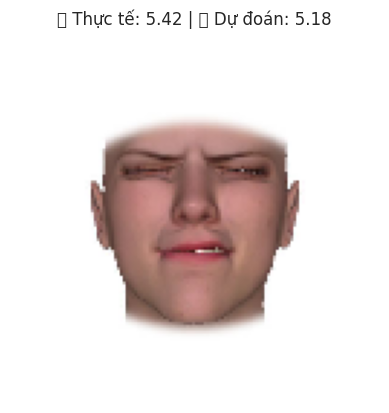

In [100]:
# 👉 Lấy 1 mẫu ảnh từ tập test để thử nghiệm
idx = 0  # hoặc chọn ngẫu nhiên: random.randint(0, len(X_img_test)-1)

img_sample = np.expand_dims(X_img_test[idx], axis=0)
emo_sample = np.expand_dims(X_emo_test[idx], axis=0)
face_sample = np.expand_dims(X_face_test[idx], axis=0)

# 👉 Dự đoán
pred = model.predict([img_sample, emo_sample, face_sample])[0][0]

# 👉 Hiển thị kết quả
plt.imshow(X_img_test[idx])
plt.axis('off')
plt.title(f"🎯 Thực tế: {y_test[idx]:.2f} | 🤖 Dự đoán: {pred:.2f}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


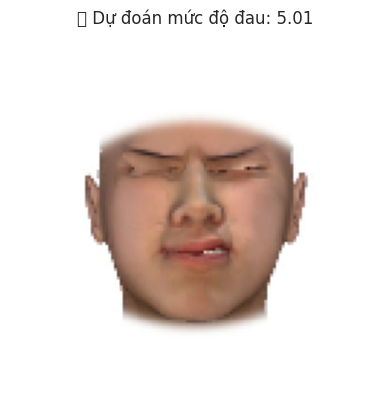

In [92]:
# 👉 Đường dẫn ảnh test mới
img_path = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller/AF1/AF1_PMS7.jpg"
image_file_part = "EF5.jpg"  # Phần tên file khớp trong cột 'ImageFile' của CSV

# 👉 Tìm dòng tương ứng trong DataFrame
row = df[df['ImageFile'] == image_file_part]
if row.empty:
    print("❌ Không tìm thấy thông tin tương ứng trong file CSV.")
else:
    # 👉 Tiền xử lý ảnh
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 👉 Trích xuất đặc trưng cảm xúc và khuôn mặt
    emotion_input_sample = np.expand_dims(row[emotion_features].values[0], axis=0)
    face_input_sample = np.expand_dims(row[face_features].values[0], axis=0)

    # 👉 Dự đoán
    predicted_pain = model.predict([img_array, emotion_input_sample, face_input_sample])[0][0]

    # 👉 Hiển thị kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🤖 Dự đoán mức độ đau: {predicted_pain:.2f}")
    plt.show()



In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 👉 Đường dẫn ảnh test
img_path = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller/AF1/AF1.jpg"

# 👉 Tách hậu tố để tìm dòng trong CSV
filename = os.path.basename(img_path)            # "AF1_EF5.jpg"
suffix = filename.split('_')[-1]                 # "EF5.jpg"

# 👉 Tìm dòng khớp trong CSV
row = df[df['ImageFile'] == suffix]

if row.empty:
    print(f"❌ Không tìm thấy dòng nào có ImageFile = '{suffix}' trong CSV.")
else:
    row = row.iloc[0]

    # 👉 Tiền xử lý ảnh
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 👉 Trích xuất đặc trưng
    emotion_input_sample = np.expand_dims(row[emotion_features].values.astype(float), axis=0)
    face_input_sample = np.expand_dims(row[face_features].values.astype(float), axis=0)

    # 👉 Dự đoán
    predicted_pain = model.predict([img_array, emotion_input_sample, face_input_sample])[0][0]

    # 👉 Hiển thị kết quả
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🤖 Dự đoán mức độ đau: {predicted_pain:.2f}")
    plt.show()


❌ Không tìm thấy dòng nào có ImageFile = 'AF1.jpg' trong CSV.
